# init

https://qiita.com/miya_ppp/items/f1348e9e73dd25ca6fb5


In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
from IPython.display import display

batch_size = 64 # バッチサイズ
nz = 100 # 潜在変数の次元数
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# explanation

In [14]:
torch_rand=torch.randn(batch_size, nz, device=device)
print(torch_rand.size())

torch.Size([64, 100])


# GAN

In [3]:
dataset = MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True # バッチサイズがずれると面倒くさいので最後は切り捨て
)

sample_x, _ = next(iter(dataloader))
w, h = sample_x.shape[2:] # (28, 28)
image_size = w * h        # 784


# class

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(nn.Flatten(), # 1x28x28 -> 784
            nn.Linear(image_size, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid(), # 確率なので0~1に
        )

    def forward(self, x):
        y = self.net(x)
        return y

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            self._linear(nz, 128),
            self._linear(128, 256),
            self._linear(256, 512),
            nn.Linear(512, image_size),
            nn.Sigmoid() # 濃淡を0~1に
        )

    def _linear(self, input_size, output_size):
        return nn.Sequential(
            nn.Linear(input_size, output_size),
            nn.BatchNorm1d(output_size),
            nn.ReLU()
        )

    def forward(self, x):
        y = self.net(x)
        y = y.view(-1, 1, w, h) # 784 -> 1x28x28
        return y



# learning


~~~discriminator 識別機~~~
real_labels = torch.zeros(batch_size, 1).to(device) # 本物のラベル
fake_labels = torch.ones(batch_size, 1).to(device) # 偽物のラベル
criterion = nn.BCELoss() # バイナリ交差エントロピー


z = make_noise(batch_size) # ノイズを生成
fake = netG(z) # 偽物を生成
pred_fake = netD(fake) # 偽物を判定
pred_real = netD(x) # 本物を判定
loss_fake = criterion(pred_fake, fake_labels) # 偽物の判定に対する誤差
loss_real = criterion(pred_real, real_labels) # 本物の判定に対する誤差
lossD = loss_fake + loss_real # 二つの誤差の和
lossD.backward() # 逆伝播
optimD.step() # パラメータ更新


~~~generators~~~

fake = netG(z) # 偽物を生成
pred = netD(fake) # 偽物を判定
lossG = pred.sum() # 和をとる
lossG.backward() # 逆伝播
optimG.step() # パラメータ更新

pred = netD(fake)
lossG = criterion(pred, real_labels)


In [8]:
# ノイズを生成する関数
def make_noise(batch_size):
    return torch.randn(batch_size, nz, device=device)

# 画像を描画する関数
def write(netG, n_rows=1, n_cols=8, size=64):
    z = make_noise(n_rows*n_cols)
    images = netG(z)
    images = transforms.Resize(size)(images)
    img = torchvision.utils.make_grid(images, n_cols)
    img = transforms.functional.to_pil_image(img)
    display(img)

real_labels = torch.zeros(batch_size, 1).to(device) # 本物のラベル
fake_labels = torch.ones(batch_size, 1).to(device) # 偽物のラベル
criterion = nn.BCELoss() # バイナリ交差エントロピー

# 学習を行う関数
def train(netD, netG, optimD, optimG, n_epochs, write_interval=1):
    # 学習モード
    netD.train()
    netG.train()

    for epoch in range(1, n_epochs+1):
        for x, _ in dataloader:
            x = x.to(device)

            # 勾配をリセット
            optimD.zero_grad()
            optimG.zero_grad()

            # 識別器の学習
            z = make_noise(batch_size) # ノイズを生成
            fake = netG(z) # 偽物を生成
            pred_fake = netD(fake) # 偽物を判定
            pred_real = netD(x) # 本物を判定
            loss_fake = criterion(pred_fake, fake_labels) # 偽物の判定に対する誤差
            loss_real = criterion(pred_real, real_labels) # 本物の判定に対する誤差
            lossD = loss_fake + loss_real # 二つの誤差の和
            lossD.backward() # 逆伝播
            optimD.step() # パラメータ更新

            # 生成器の学習
            fake = netG(z) # 偽物を生成
            pred = netD(fake) # 偽物を判定
            lossG = pred.sum() # 和をとる
            lossG.backward() # 逆伝播
            optimG.step() # パラメータ更新

        print(f'{epoch:>3}epoch | lossD: {lossD:.4f}, lossG: {lossG:.4f}')
        if epoch % write_interval == 0:
            write(netG) # 生成器で画像を生成し描画する


In [17]:
netD = Discriminator().to(device)
netG = Generator().to(device)

params=list(netD.parameters())

for i, param in enumerate(params):
    print(f"Parameter {i + 1}: {param.shape}")

Parameter 1: torch.Size([512, 784])
Parameter 2: torch.Size([512])
Parameter 3: torch.Size([128, 512])
Parameter 4: torch.Size([128])
Parameter 5: torch.Size([1, 128])
Parameter 6: torch.Size([1])


初期状態


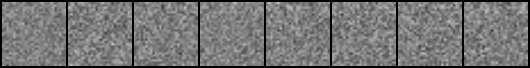

  1epoch | lossD: 0.0025, lossG: 63.8835


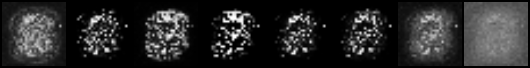

  2epoch | lossD: 0.0050, lossG: 63.8728


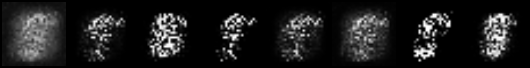

  3epoch | lossD: 0.0104, lossG: 63.7938


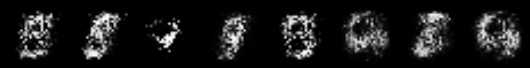

  4epoch | lossD: 0.0089, lossG: 63.6898


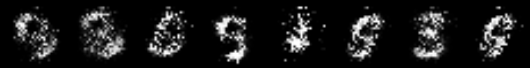

  5epoch | lossD: 0.1025, lossG: 61.9531


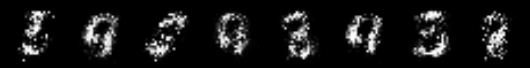

In [9]:
optimD = optim.Adam(netD.parameters(), lr=0.0002)
optimG = optim.Adam(netG.parameters(), lr=0.0002)
n_epochs = 5

print('初期状態')
write(netG)
train(netD, netG, optimD, optimG, n_epochs)


  1epoch | lossD: 0.0758, lossG: 62.0803


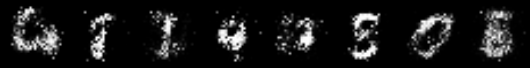

  2epoch | lossD: 0.0899, lossG: 62.5313


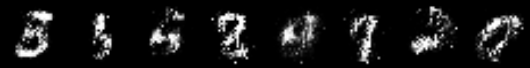

  3epoch | lossD: 0.2776, lossG: 60.9680


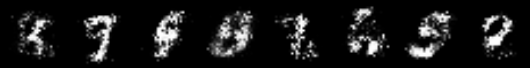

  4epoch | lossD: 0.1809, lossG: 61.8045


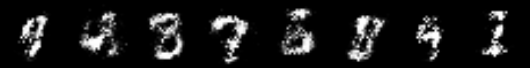

  5epoch | lossD: 0.2327, lossG: 60.5069


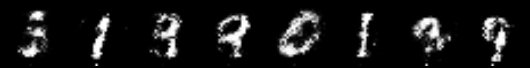

  6epoch | lossD: 0.4684, lossG: 54.2387


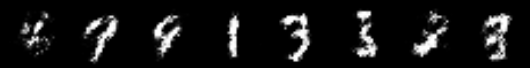

  7epoch | lossD: 0.3987, lossG: 56.5320


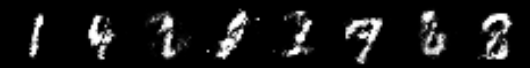

  8epoch | lossD: 0.4046, lossG: 54.9456


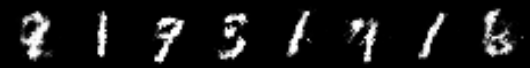

  9epoch | lossD: 0.4599, lossG: 53.3198


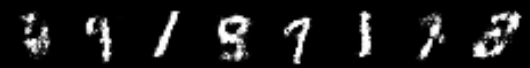

 10epoch | lossD: 0.4604, lossG: 55.8768


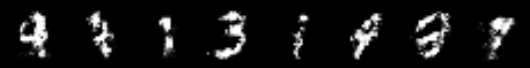

 11epoch | lossD: 0.8256, lossG: 51.2955


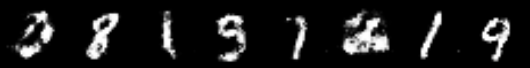

 12epoch | lossD: 0.7408, lossG: 49.9055


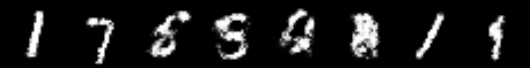

 13epoch | lossD: 0.8094, lossG: 48.5490


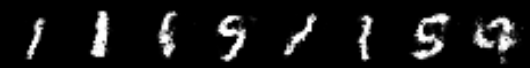

 14epoch | lossD: 0.5095, lossG: 52.9980


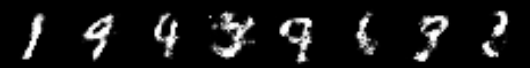

 15epoch | lossD: 0.7850, lossG: 47.9559


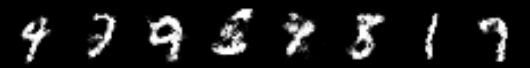

 16epoch | lossD: 0.9087, lossG: 46.2841


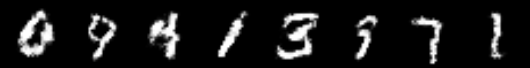

 17epoch | lossD: 0.8512, lossG: 45.9440


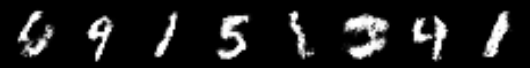

 18epoch | lossD: 0.7205, lossG: 48.6854


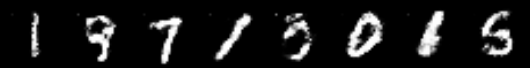

 19epoch | lossD: 1.0840, lossG: 44.6862


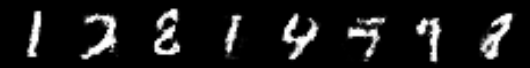

 20epoch | lossD: 1.0544, lossG: 44.0935


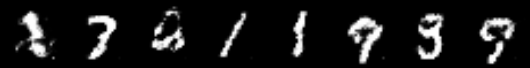

In [10]:
train(netD, netG, optimD, optimG, 20)